# Vehicle Insurance Fraud Detection

# About Dataset

The dataset is an automobile insurance dataset “carclaims”, which is publically available and is provided by Angoss Knowledge Seeker. It has 15420 samples, of which 14497 are legitimate and 923 fraudulent, which indicates high class imbalance.

# Introduction

Fraud costs companies worldwide billions and billions of Euros per year, from workers who call sick to work to false claims. It is common to see a fraud detection department in every big company to reduce the cost of "cheating". One sector always targeted is insurance, and they put extra care and resources hoping to cut their losses regarding this matter.

For this project, we use an actual case where the dataset contains several features that relate to them to archive a "profile" of customers and a behavioural pattern for fraud commitment. Also, the dataset has a high-class imbalance, with only a 6% being a fraud.

The dataset used for this project is https://www.kaggle.com/datasets/khusheekapoor/vehicle-insurance-fraud-detection to find.

# Project Goals

We set up two different goals; the first is to discover the proportion of the fraud occurring with the given data, which will allow us to consider an adjustment in the car policy prices regarding the variables.

The second one is to create a model to predict fraud and create a warning of possible fraud. It is essential for the analysis that Error type II is the lowest possible to avoid fraud with a moderate error type I not to drain company resources.

# LIbraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=[10,8]
import scipy.stats as stats
pd.options.display.max_columns=None
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_auc_score,roc_curve


#for model building
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB


#For balancing the data
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

#for confusion matrix
from sklearn.metrics import confusion_matrix



# Understanding the data

In [2]:
data = pd.read_csv('carclaims.csv')

data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,PolicyNumber,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


converting target variable to 1 and 0

In [3]:
data['FraudFound']=data['FraudFound'].map({'No':0,'Yes':1})

In [4]:
# Policy number is unique column so we will drop it

data.drop('PolicyNumber',axis=1,inplace=True)

In [5]:
data.shape
print('NO OF ROWS : ' , data.shape[0])
print('NO OF COLUMNS  :'  ,data.shape[1])

#Thre are 33 feature and 15420 rows are in the data.

NO OF ROWS :  15420
NO OF COLUMNS  : 32


In [6]:
data.isnull().sum().sum()
print('NULL VALUE IN THE DATA :' , data.isnull().sum().sum())

NULL VALUE IN THE DATA : 0


In [7]:
data.duplicated().sum()
print('DUPLICATED VALUES IN THE DATA :' ,data.duplicated().sum())

DUPLICATED VALUES IN THE DATA : 0


In [8]:
num_cols = data.select_dtypes(include=np.number).columns
cat_cols= data.select_dtypes(include='object').columns
print('Total numerical columns are:',len(num_cols))
print('Total Categorical columns are:',len(cat_cols))
print('Total Number of rows in data:',len(data))

Total numerical columns are: 8
Total Categorical columns are: 24
Total Number of rows in data: 15420


In [9]:
print('NUMERICAL COLUMNS IN DATA  :--' ,num_cols)

NUMERICAL COLUMNS IN DATA  :-- Index(['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'RepNumber', 'Deductible',
       'DriverRating', 'Year', 'FraudFound'],
      dtype='object')


In [10]:
print('CATEGORICAL COLUMNS IN THE DATA : --' ,cat_cols)

CATEGORICAL COLUMNS IN THE DATA : -- Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'Days:Policy-Accident',
       'Days:Policy-Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars',
       'BasePolicy'],
      dtype='object')


* The value counts checaking for all categorical variables.To understand the variables.   

In [11]:
for i in cat_cols:
    print(i)
    print(data[i].value_counts(normalize=True)*100)
    print('-'*50)
    
#The value counts checaking for all categorical variables.To understand the variables.   

Month
Jan    9.150454
May    8.865110
Mar    8.819715
Jun    8.566796
Oct    8.463035
Dec    8.333333
Apr    8.300908
Feb    8.210117
Jul    8.151751
Sep    8.041505
Nov    7.788586
Aug    7.308690
Name: Month, dtype: float64
--------------------------------------------------
DayOfWeek
Monday       16.964981
Friday       15.856031
Tuesday      14.915694
Thursday     14.092088
Wednesday    14.001297
Saturday     12.853437
Sunday       11.316472
Name: DayOfWeek, dtype: float64
--------------------------------------------------
Make
Pontiac      24.883268
Toyota       20.239948
Honda        18.164721
Mazda        15.265888
Chevrolet    10.901427
Accura        3.060960
Ford          2.918288
VW            1.835279
Dodge         0.706874
Saab          0.700389
Mercury       0.538262
Saturn        0.376135
Nisson        0.194553
BMW           0.097276
Jaguar        0.038911
Porche        0.032425
Mecedes       0.025940
Ferrari       0.012970
Lexus         0.006485
Name: Make, dtype: float64


# UNDERSTANDING THE OUTLIERS

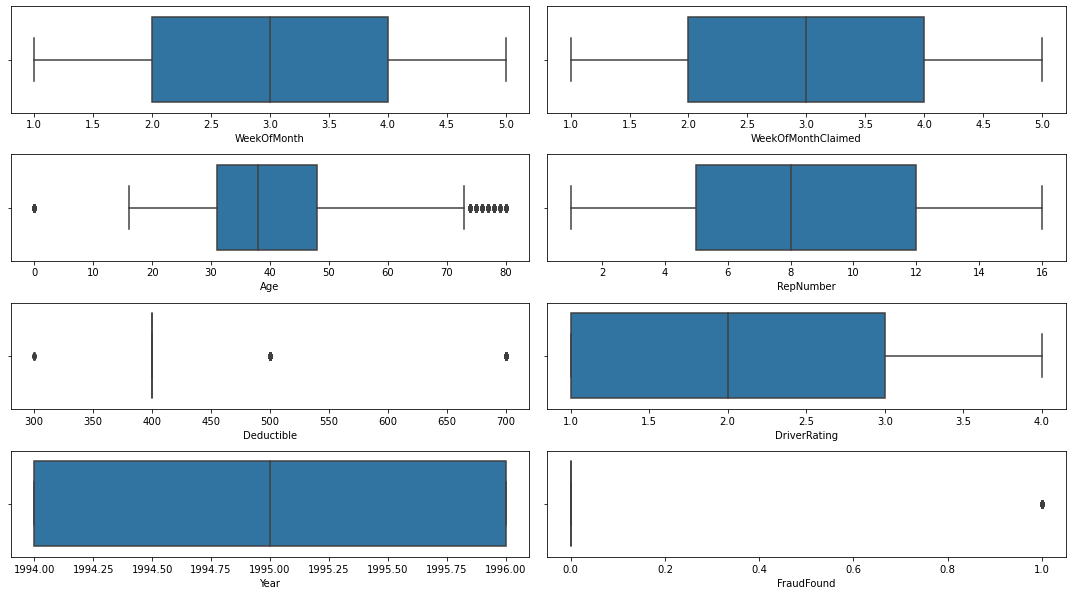

In [12]:
# Checking Outliers of the data
plt.figure(figsize=(15,10))
a = 1
for i in num_cols:
    plt.subplot(5,2,a)
    sns.boxplot(data[i])
    a+=1
plt.tight_layout()

Treatment of the outliers

In [13]:
# Converting deductible to object

data['Deductible']=data['Deductible'].astype('object')

In [14]:
num_cols = data.select_dtypes(include=np.number).columns
cat_cols= data.select_dtypes(include='object').columns

In [15]:
#  Age and age of policy holder were two columns where age had 0 values 
# but for same rows age of policy holder had group of 16 to 17. As age cant be
# 0 so it was replaced with 17 because 17 is close to legal age of driving And
# Age of policy holder was dropped after treating zeros


def ageg(x):
    if x==0:
        return 17
    else:
        return x
    
data['Age']=data['Age'].apply(ageg)

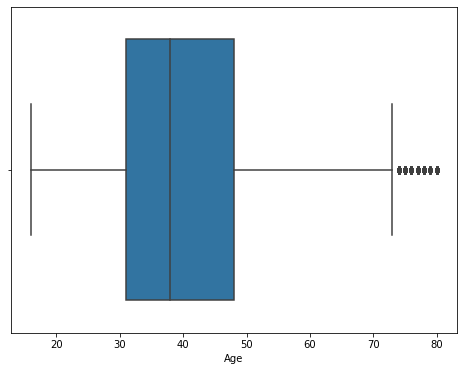

In [16]:
plt.figure(figsize=(8,6))
sns.boxplot(data['Age'])
plt.show()

# Cheacking the distribution of the data

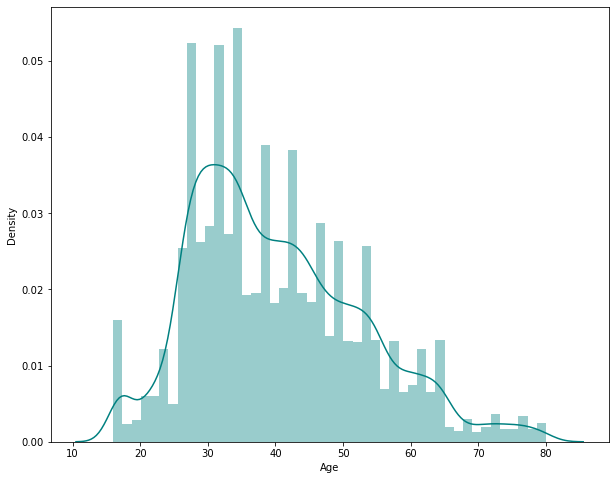

In [17]:
# Checking for distribution of the data
sns.distplot(data['Age'],color='teal')
plt.show()

# Univariate Analysis

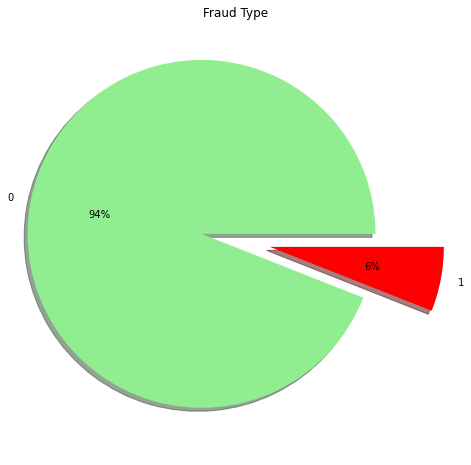

In [18]:
plt.figure(figsize=(10,8))
plt.pie(data.FraudFound.value_counts().values,labels=data.FraudFound.value_counts().index,
        autopct='%.0f%%',shadow=True,explode=[0.2,0.2],colors=['lightgreen','r'])
plt.title("Fraud Type")
plt.show()

# Data is highly Imbalance

Cheacking the correlation and multi-collinearity

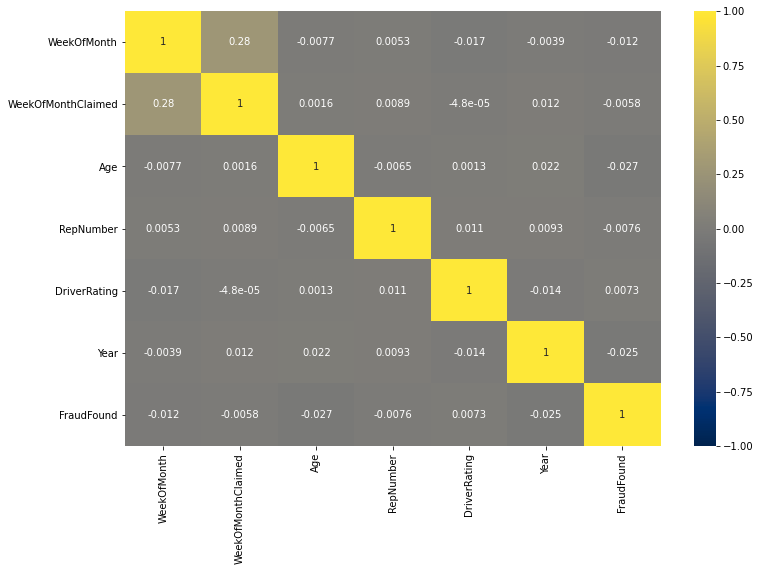

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(),annot=True,cmap='cividis',vmax=1,vmin=-1)
plt.show()

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [21]:
vif=pd.DataFrame()
num_cols=data.select_dtypes(include=np.number)
num_cols=num_cols.drop('FraudFound',axis=1)
vif['FraudFound']=num_cols.columns
vif['VIF']=[variance_inflation_factor(num_cols.values,i)for i in range(num_cols.shape[1])]
vif

,FraudFound,VIF
0,WeekOfMonth,6.160128
1,WeekOfMonthClaimed,6.036549
2,Age,11.120109
3,RepNumber,4.402504
4,DriverRating,5.941525
5,Year,26.807471


In [22]:
vif=pd.DataFrame()
num_cols=data.drop('Year',axis=1).select_dtypes(include=np.number)
num_cols=num_cols.drop('FraudFound',axis=1)
vif['FraudFound']=num_cols.columns
vif['VIF']=[variance_inflation_factor(num_cols.values,i)
            for i in range(num_cols.shape[1])]
vif

,FraudFound,VIF
0,WeekOfMonth,5.495723
1,WeekOfMonthClaimed,5.482672
2,Age,6.869792
3,RepNumber,3.860580
4,DriverRating,4.841838


In [23]:
data.drop('Year',axis=1,inplace=True)

Relationship between variables

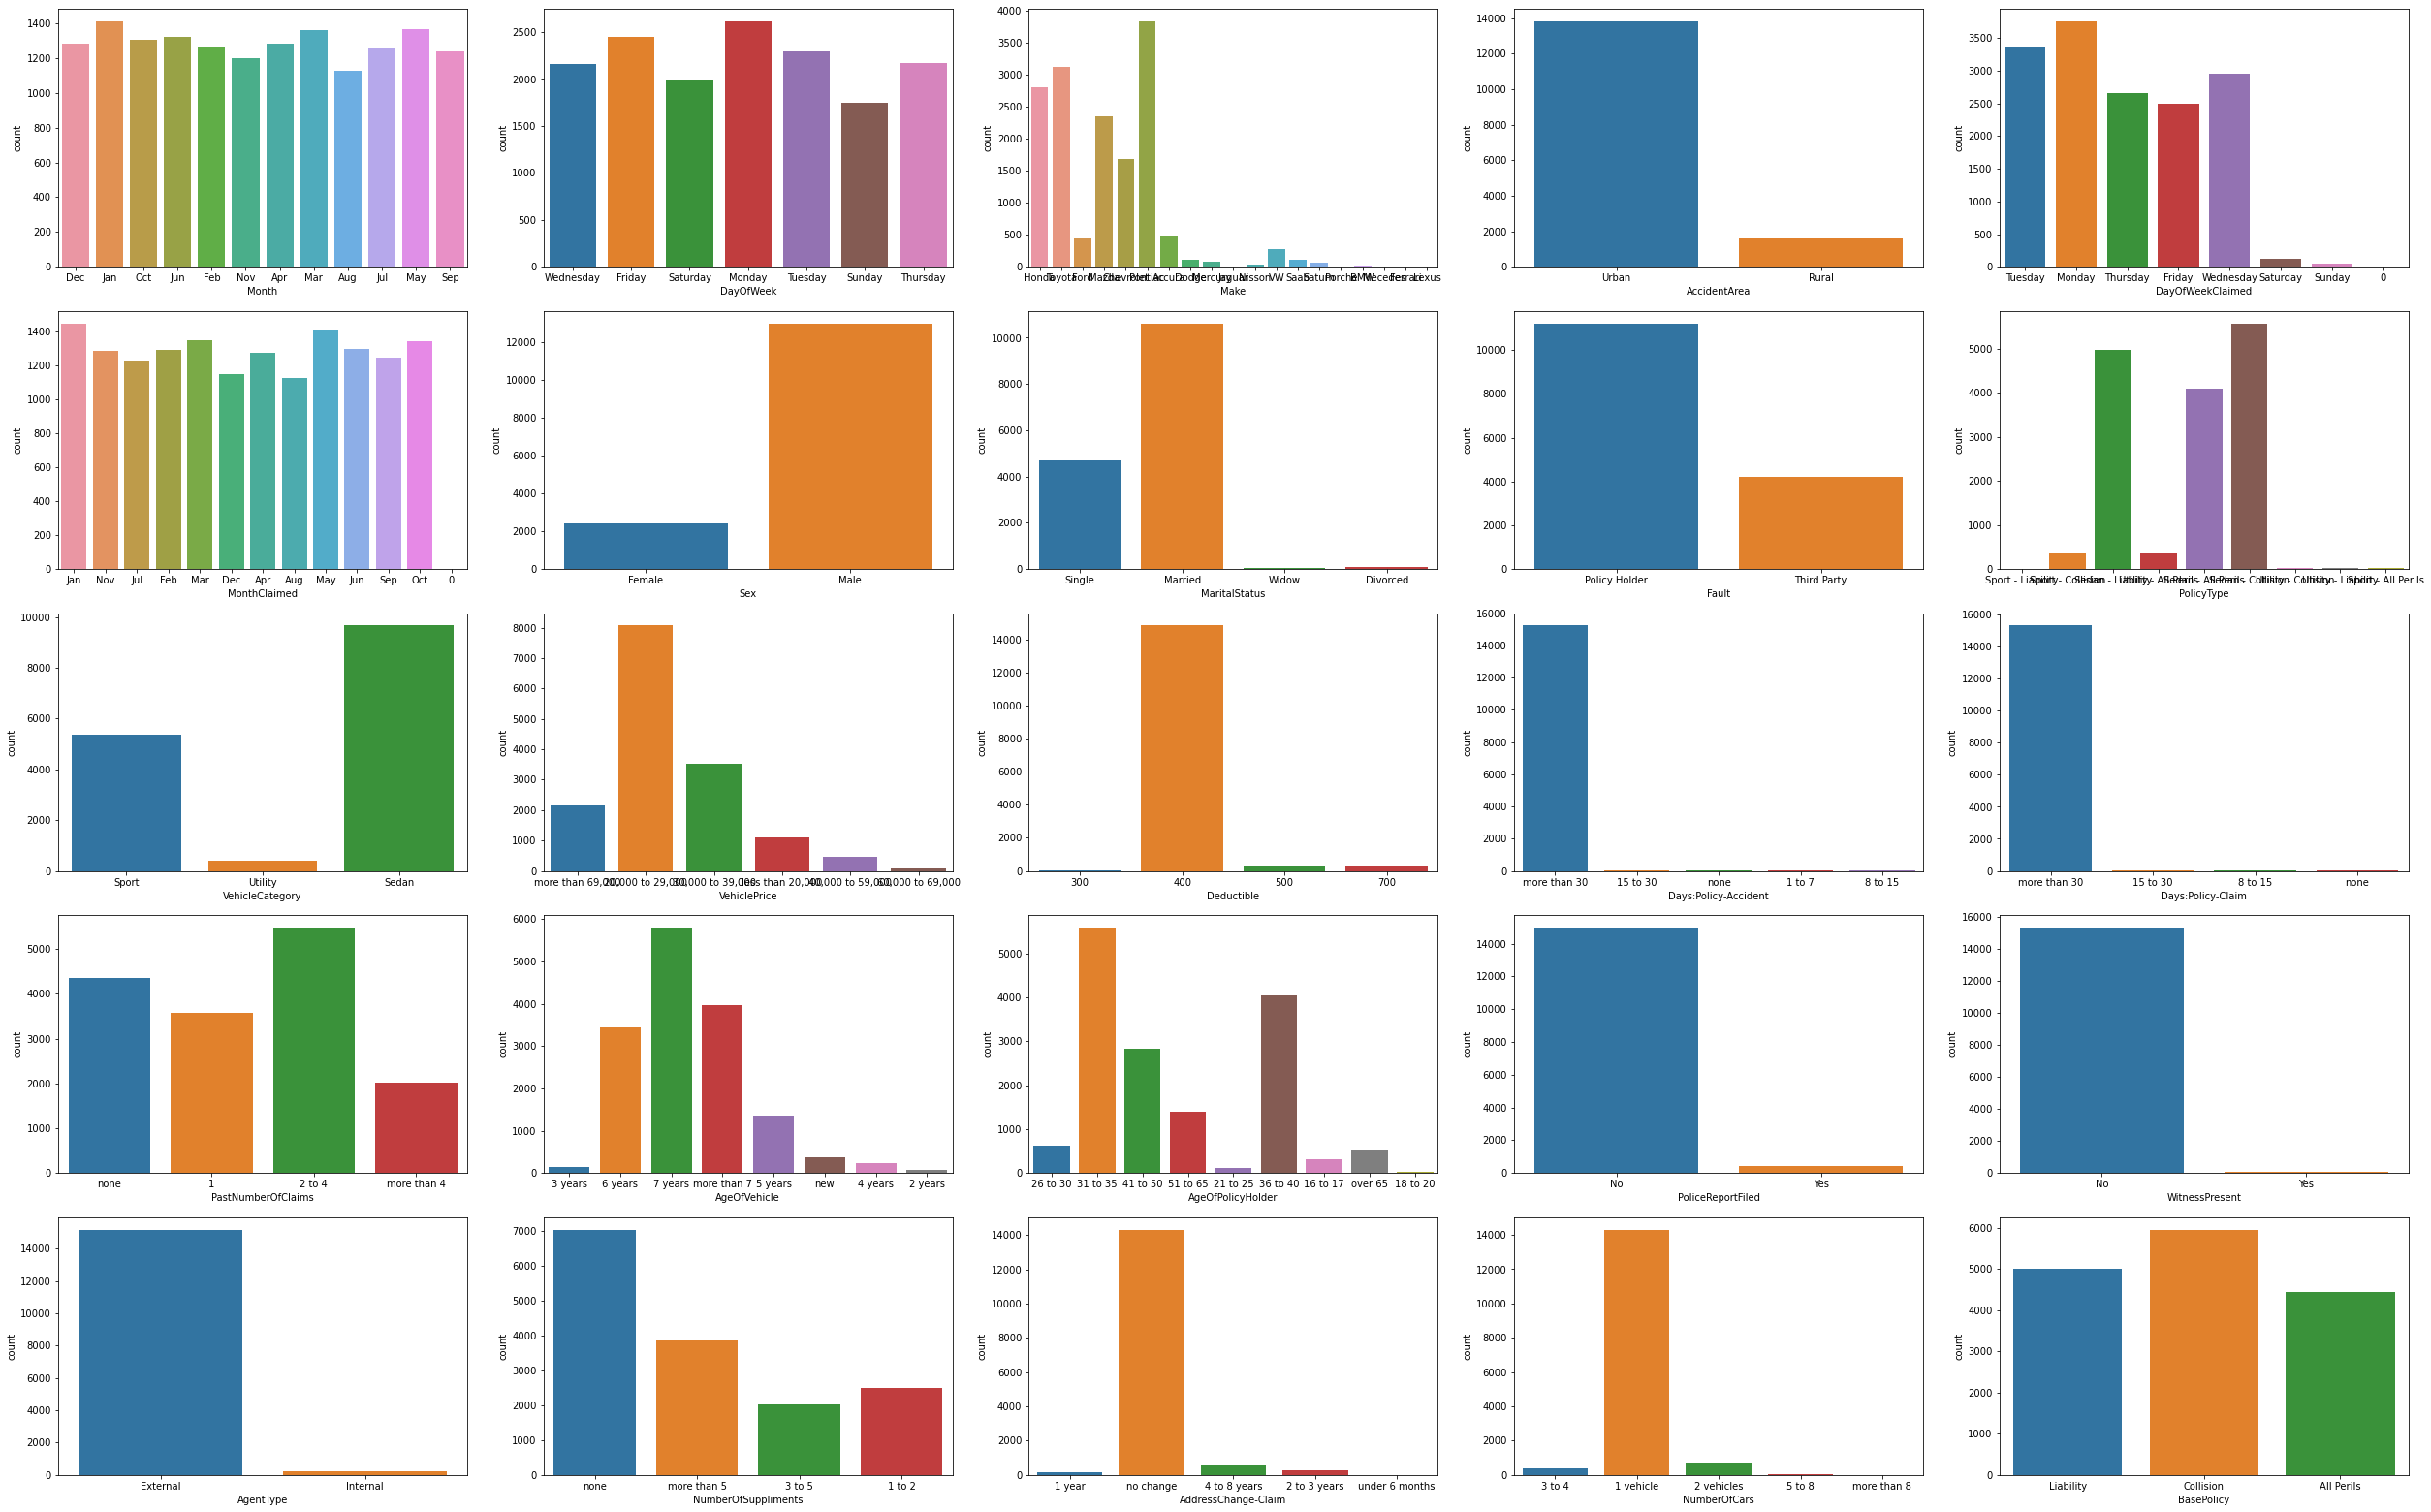

In [24]:
plt.figure(figsize=(35,30))
a = 1
for i in cat_cols:
    plt.subplot(7,5,a)
    sns.countplot(data[i])
    a+=1
plt.tight_layout()

# Jan,Mar and May has been registered with maximum number of ACCIDENTS
# Weekdays have the highest number of ACCIDENTS as compared to weekends
# Premium cars has less insruance claim and vehicles with lowest prices has highest claims
# Most of the claims and accidents are done one weekdays and are from Urban area
# Most of claimants are male 
# Most of the claimants are married followed by single
# Most of the vehicle category is Sedan
# Most of the claims have no witness present and no police reports are filed


# Bivariate Analysis

<Figure size 360x1080 with 0 Axes>

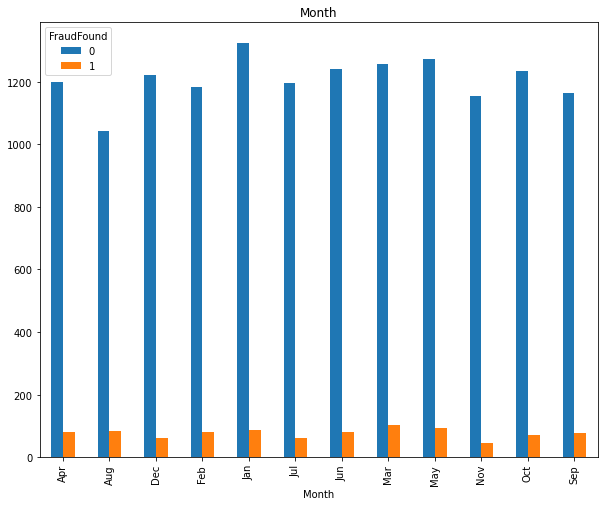

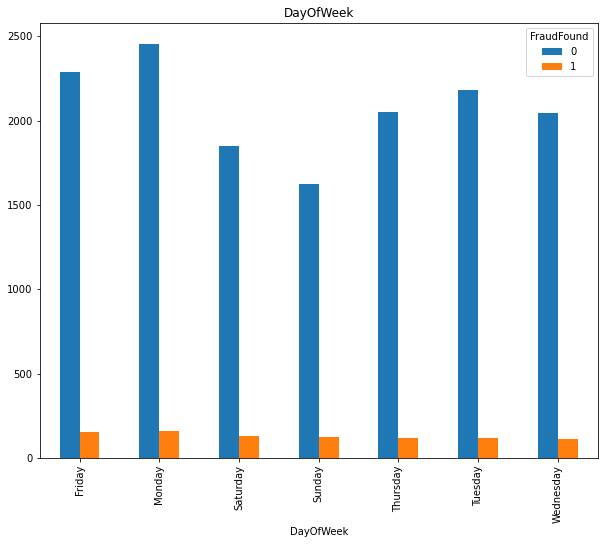

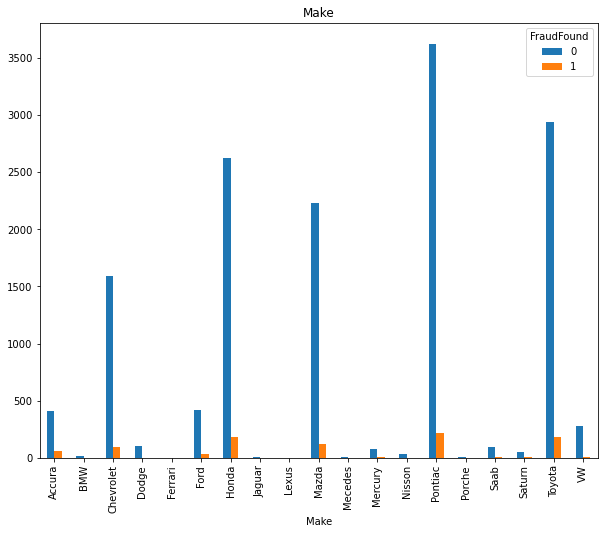

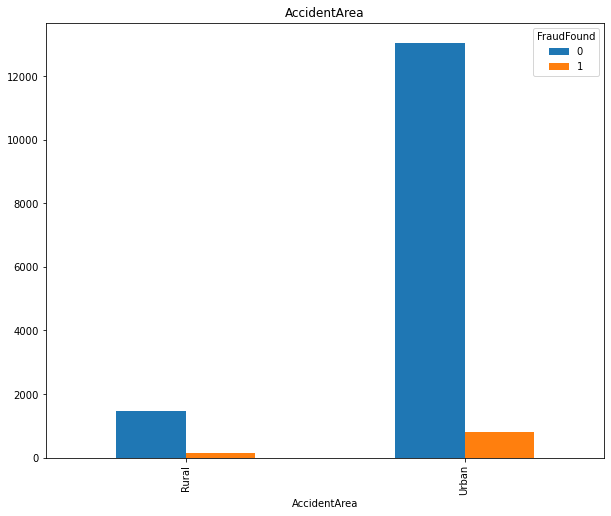

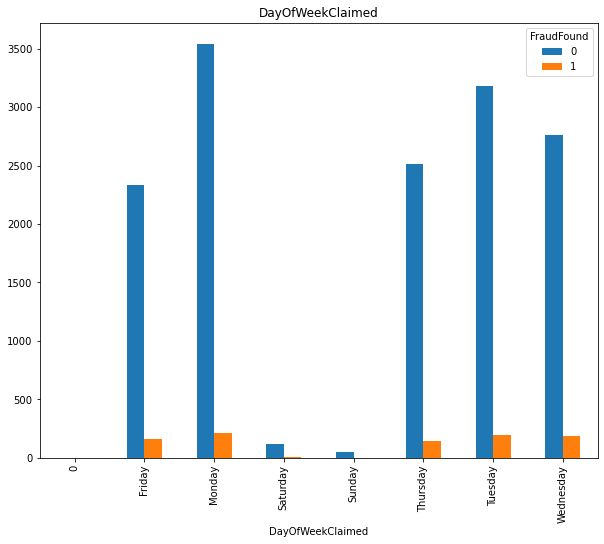

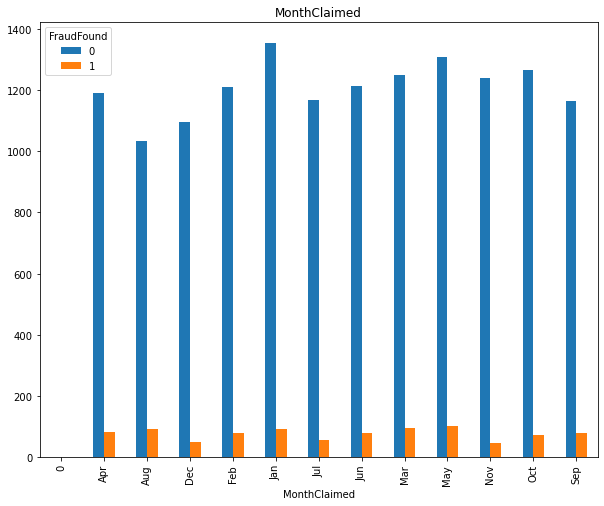

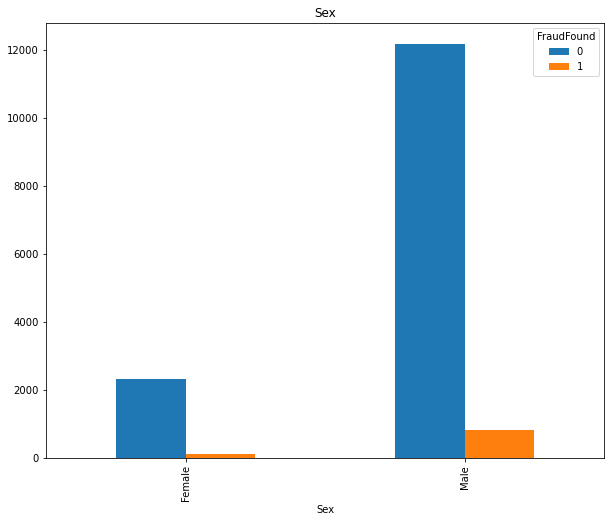

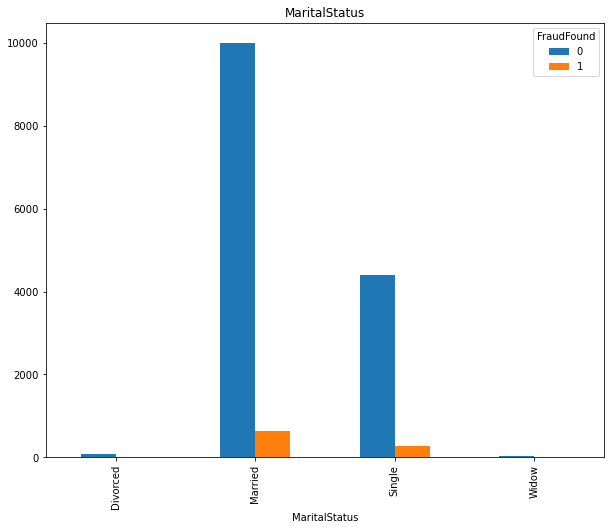

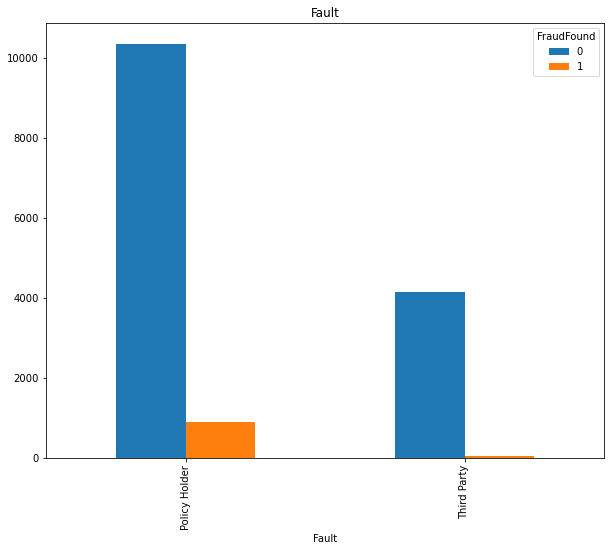

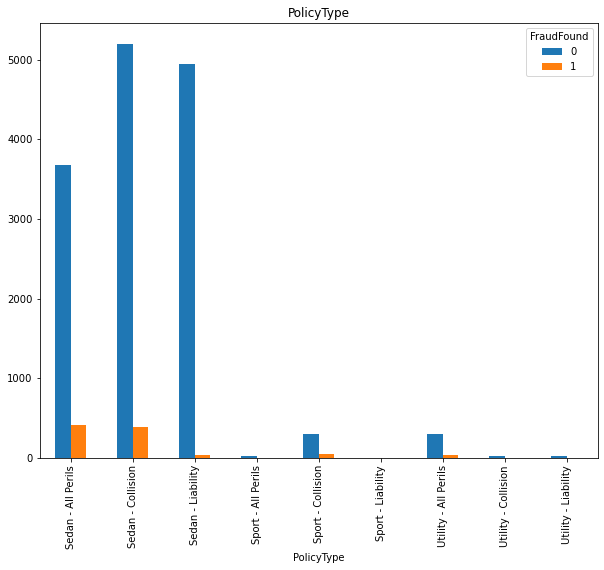

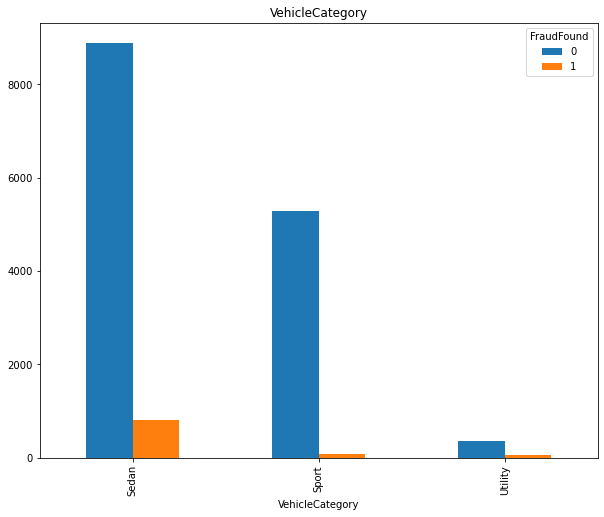

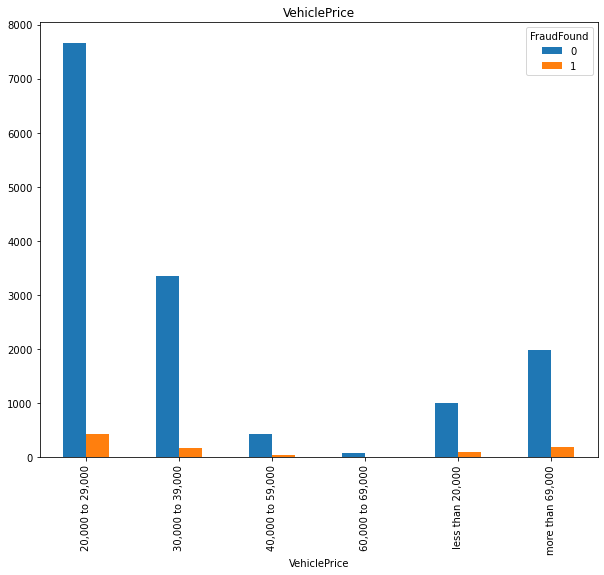

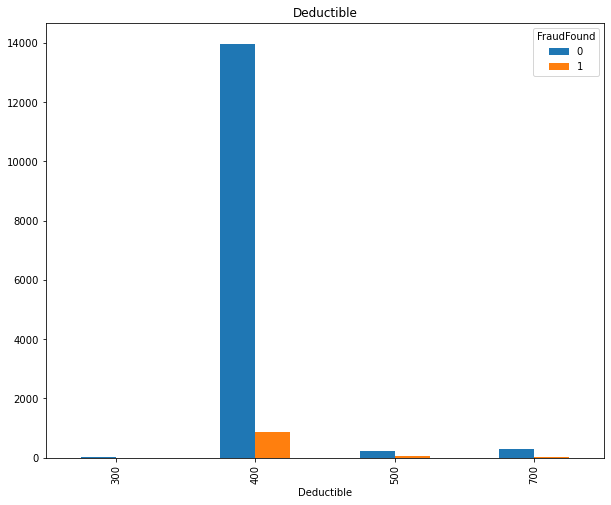

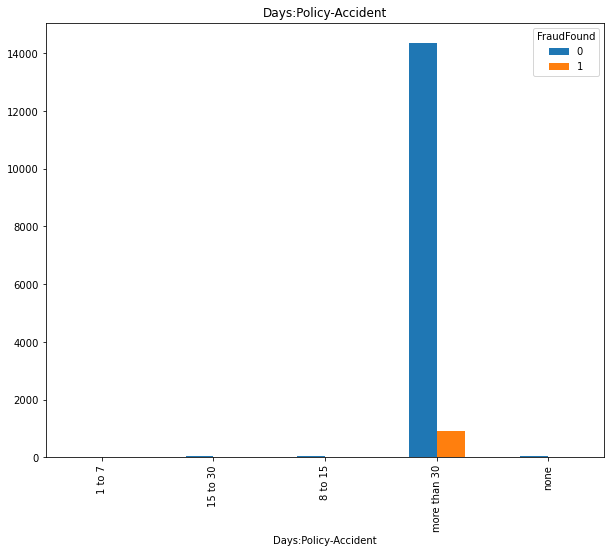

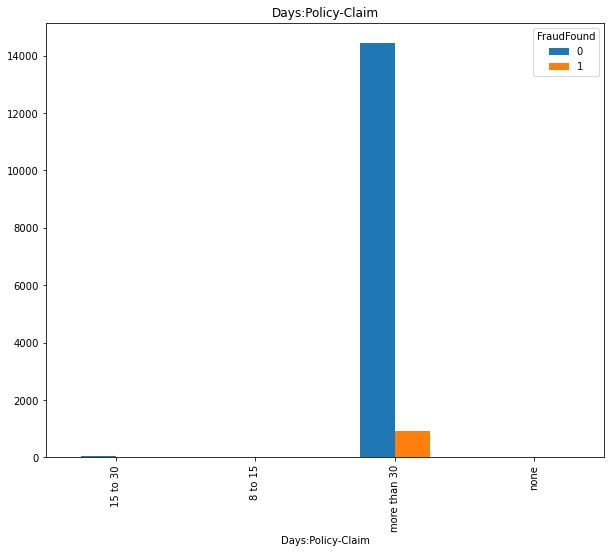

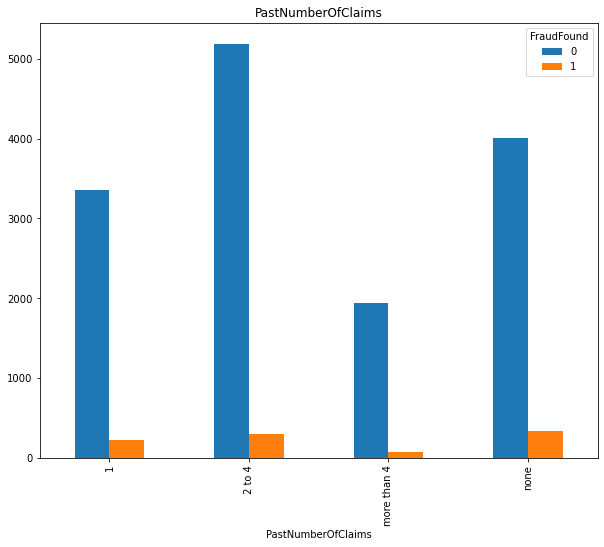

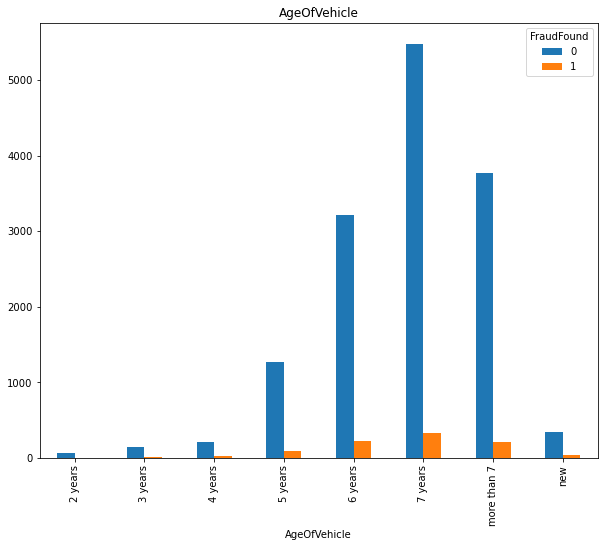

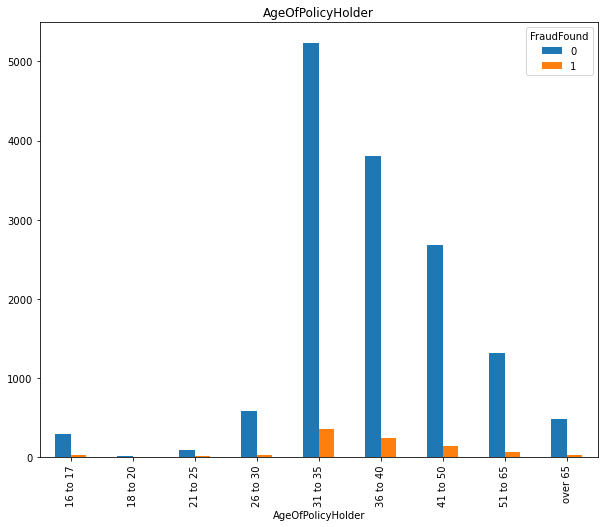

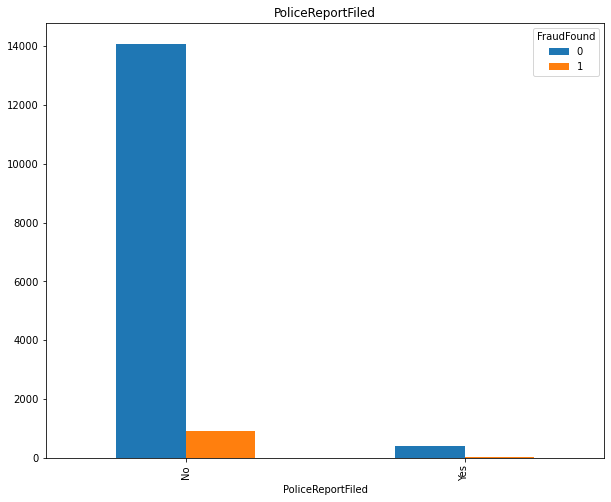

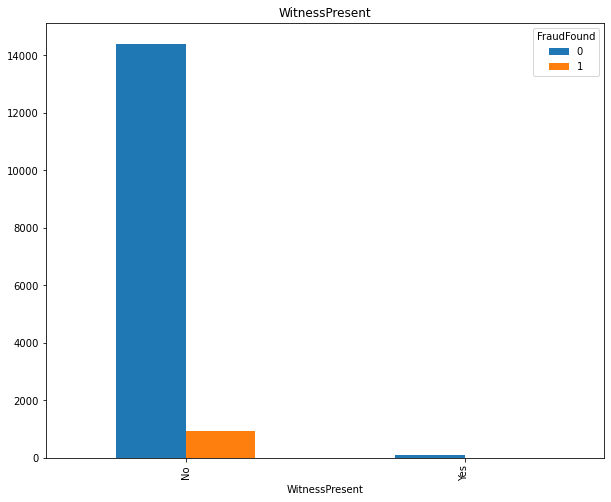

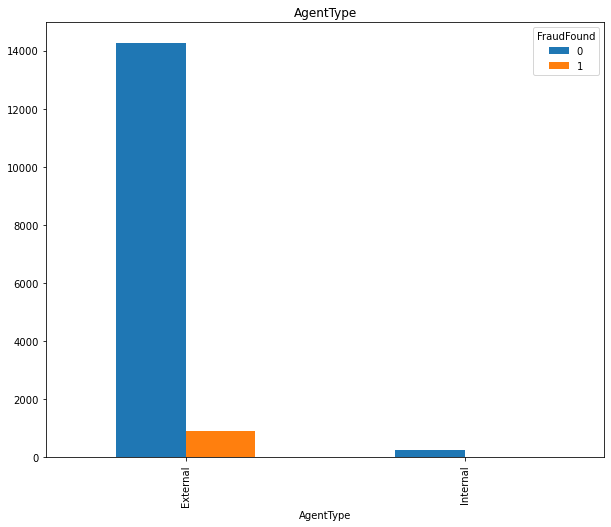

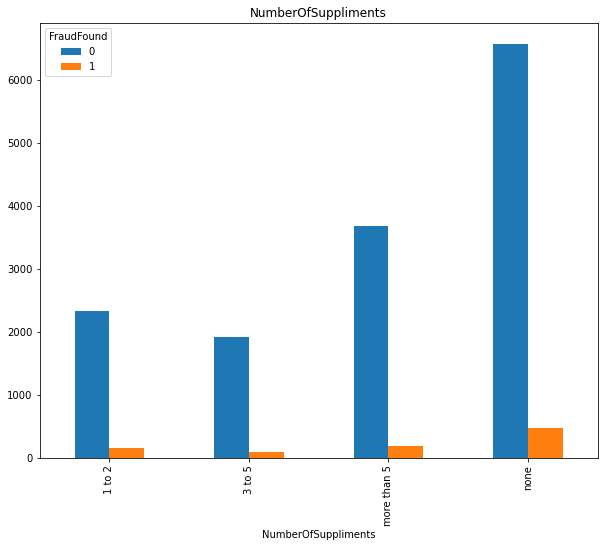

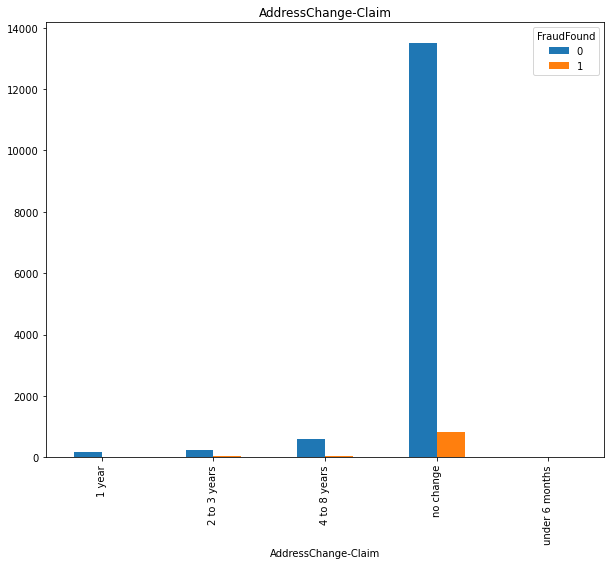

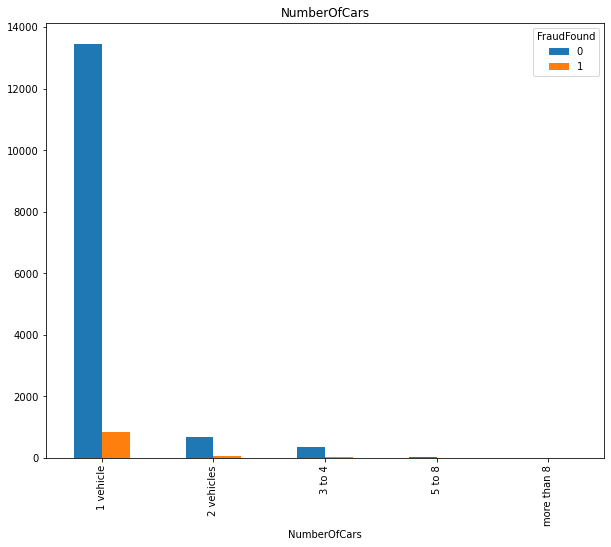

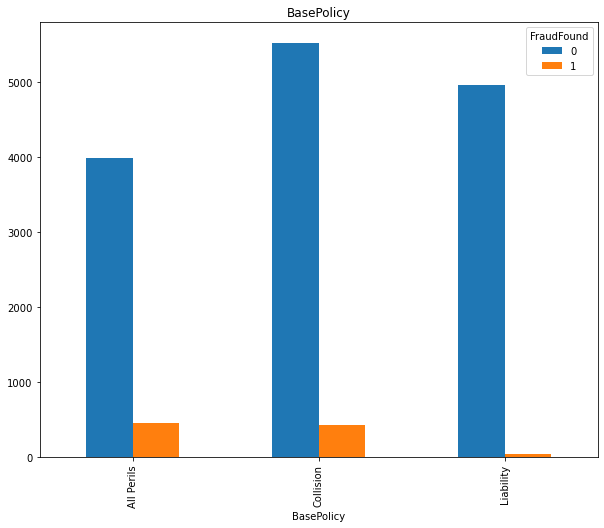

In [25]:
plt.figure(figsize=(5,15))
for i in cat_cols:                                                         #cat vs cat
    pd.crosstab(data.loc[:,i],data.FraudFound).plot(kind='bar')
    plt.title(i)
plt.show()

# Most of the Accidents are found in month of March,May,August and January while less frauds are found in month of Nov
# Most of the Accidents are found on Monday and Friday
#Most of the fraud claims are found to be of Pontaic, Toyota, Honda companies while Ford and Accura are found with less
#fraud claims
# Most of the fraud claims are found in urban areas compared with rural
# Most of fraud claims are found on Monday, Tuesday and Wednesday
# Most of the fraud insurance claims are found in month of Januray, March, May, August 
# Men has claimed fraud insurance in comparison to 
# Married population claimed more fraud insurance in comparison to single,divorced,widow
# Most of the frauds claims of insurance aare claimed by Policy holders with respect to third party
# Large number of fraud claims are found of sedan vehicaltype followed by sport and utility
# Most of the fraud claims are found in cars costing from 20,000 to 29,000
# age of vehicles under fraud claims of policy is 7 years
# Age of fraud claimants is between 31 to 35
# Most of fraud claimants has not registered police report
# Theres no witness persent in case of fraud claimants
# No of vehicles with fraud claimants is found to be 1


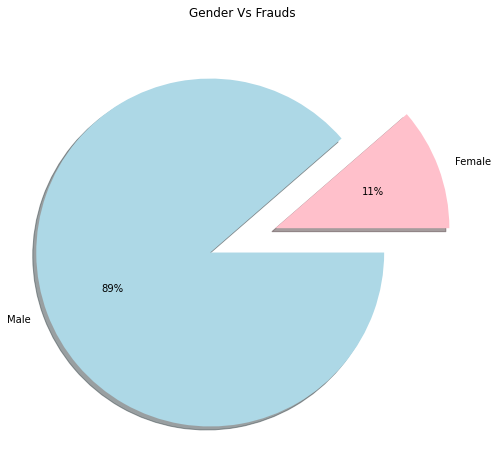

In [26]:
gender = data.groupby('Sex')['FraudFound'].sum()
plt.figure(figsize=(10,8))
plt.title("Gender Vs Frauds")

plt.pie(gender.values,labels=gender.index,  autopct='%.0f%%',shadow=True,explode=[0.2,0.2],colors=['pink','lightblue'])

plt.show()


* Bivariate analysis for categorical and target variable

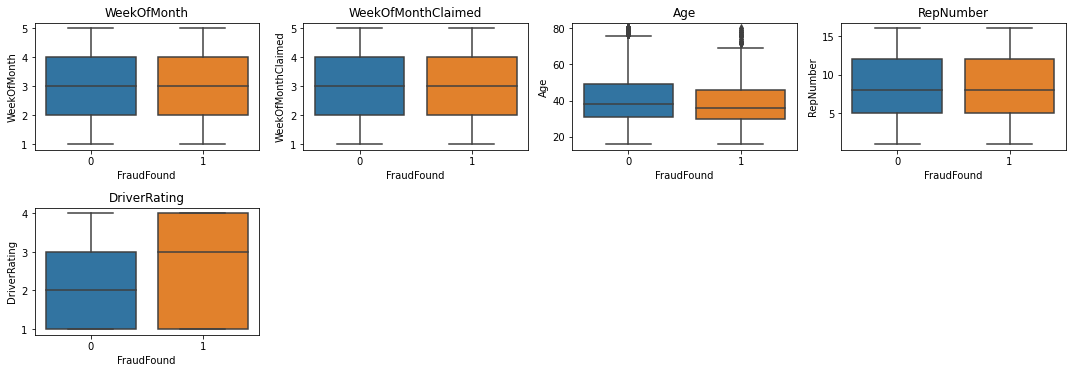

In [27]:
# Bivariate analysis for categorical and target variable

plt.figure(figsize=(15,10))
a=1
for i in num_cols:
    plt.subplot(4,4,a)
    sns.boxplot(data['FraudFound'],data[i])
    a+=1
    plt.title(i)
    plt.tight_layout()

# Statistical test

In [28]:
import scipy.stats as stats
sig_cat=[]
for i in cat_cols:
    tb=pd.crosstab(data.loc[:,i],data.FraudFound)
    teststats,pvalue,df,exp_freq= stats.chi2_contingency(tb)
    if(pvalue<0.05):
        print(i)
        sig_cat.append(i)

Month
Make
AccidentArea
MonthClaimed
Sex
Fault
PolicyType
VehicleCategory
VehiclePrice
Deductible
Days:Policy-Accident
PastNumberOfClaims
AgeOfVehicle
AgeOfPolicyHolder
AgentType
NumberOfSuppliments
AddressChange-Claim
BasePolicy


In [29]:
sig_num1=[]

for i in num_cols:
    zero= data.loc[data.FraudFound==0,i]
    one= data.loc[data.FraudFound==1,i]
    teststats,pvalue = stats.ttest_ind(zero,one)
    if pvalue<0.05:
        sig_num1.append(i)
        print(i)

Age


# Building Base Model

* Encoding


In [30]:
df1=pd.get_dummies(data,drop_first=True)

In [31]:
df1.shape

(15420, 125)

* 1.Desicion Tree

In [32]:
x= df1.drop('FraudFound',axis=1)
y=df1['FraudFound']

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [34]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,stratify=y,test_size=0.3)

In [35]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()

In [36]:
model_lr=lr.fit(xtrain,ytrain)
pred_lr=model_lr.predict(xtest)
print(classification_report(ytest,pred_lr))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.00      0.00      0.00       277

    accuracy                           0.94      4626
   macro avg       0.47      0.50      0.48      4626
weighted avg       0.88      0.94      0.91      4626



In [37]:
print('Accuracy:',np.round(accuracy_score(ytest,pred_lr),2))
print('F1-Score:',np.round(f1_score(ytest,pred_lr),2))
print('Precision score:',np.round(precision_score(ytest,pred_lr),2))
print('Recall score:',np.round(recall_score(ytest,pred_lr),2))

Accuracy: 0.94
F1-Score: 0.0
Precision score: 0.0
Recall score: 0.0


* Checking the features which are highly affecting the target variable                                  

In [38]:
pd.DataFrame(lr.coef_.T,index=x.columns,columns=['IMP']).sort_values(by='IMP',ascending=False).head(10)

,IMP
PolicyType_Sport - Collision,0.618134
AddressChange-Claim_2 to 3 years,0.448501
Deductible_500,0.390597
MonthClaimed_Aug,0.334830
AgeOfVehicle_4 years,0.323905
Sex_Male,0.277229
"VehiclePrice_40,000 to 59,000",0.269226
AgeOfVehicle_5 years,0.264666
"VehiclePrice_more than 69,000",0.235760
Month_Feb,0.218669


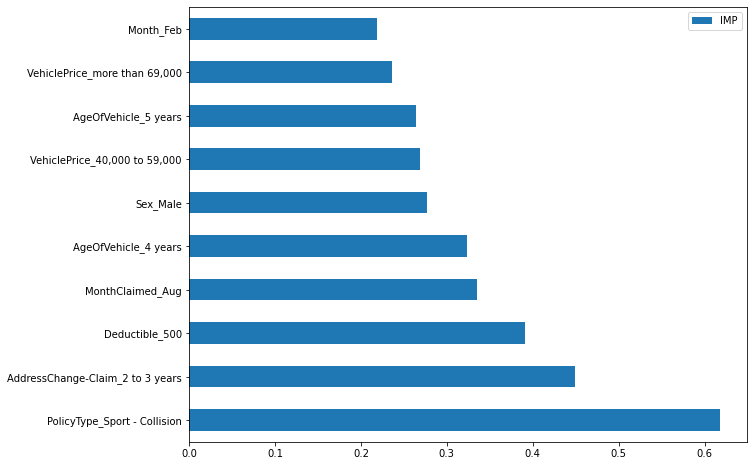

In [39]:
pd.DataFrame(lr.coef_.T,index=x.columns,columns=['IMP']).sort_values(by='IMP',ascending=False).head(10).plot(kind='barh')
plt.show()



# Feature Engineering

In [40]:
data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,Liability,0
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,Collision,0
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,Collision,0
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,Liability,0
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision,0


* converting column which are categorical in the nature to object 


In [41]:
# converting column which are categorical in the nature to object 

data['WeekOfMonth']=data['WeekOfMonth'].astype('object')
data['WeekOfMonthClaimed']=data['WeekOfMonthClaimed'].astype('object')
data['DriverRating']=data['DriverRating'].astype('object')
data['RepNumber']=data['RepNumber'].astype('object')

In [42]:
# For Month and Monthclaimed columns

#  Column named month claimed had 12 months so it was binned according to quarter for
# eg: 'Jan', 'Feb', 'March' in Q1 and so on.


def monthcat(x):
    if x in ['Jan','Feb','Mar']:
        return 'Q1'
    if x in ['Apr','May','Jun']:
        return 'Q2'
    if x in ['Jul','Aug','Sep']:
        return 'Q3'
    else:
        return 'Q4'
    
data['Month']=data['Month'].apply(monthcat)

data['MonthClaimed']=data['MonthClaimed'].apply(monthcat)

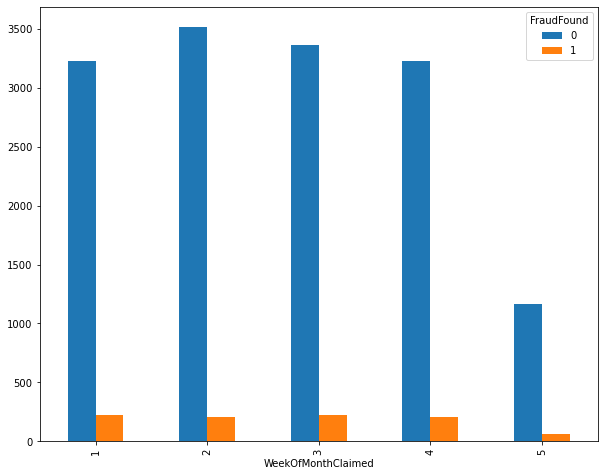

In [43]:
# For Weekofmonth and Weekofmonthclaimed column

pd.crosstab(data['WeekOfMonthClaimed'],data['FraudFound']).plot(kind='bar')
plt.show()

# We are unable to find any pattern in week column also the significance value is high so we will drop it 

data.drop('WeekOfMonthClaimed',axis=1,inplace=True)
data.drop('WeekOfMonth',axis=1,inplace=True)

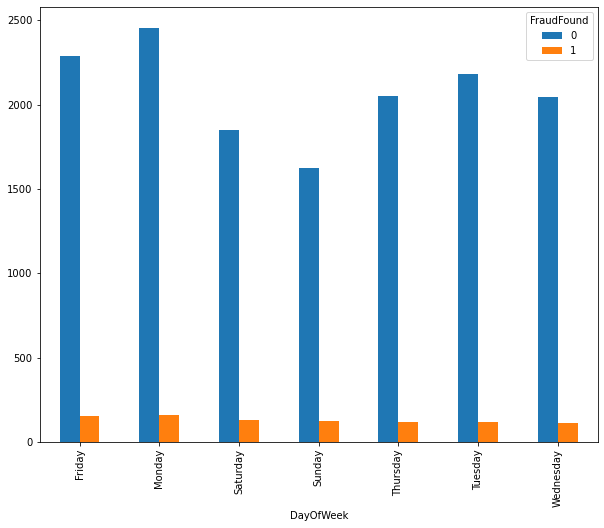

In [44]:
# For dayofweek and dayofweekclaimed columns

pd.crosstab(data['DayOfWeek'],data['FraudFound']).plot(kind='bar')
plt.show()

# We are unable to find any pattern in Day column also the significance value is high so we will drop it

data.drop(['DayOfWeek','DayOfWeekClaimed'],axis=1,inplace=True)

In [45]:
data['Make'].value_counts(normalize=True)*100

Pontiac      24.883268
Toyota       20.239948
Honda        18.164721
Mazda        15.265888
Chevrolet    10.901427
Accura        3.060960
Ford          2.918288
VW            1.835279
Dodge         0.706874
Saab          0.700389
Mercury       0.538262
Saturn        0.376135
Nisson        0.194553
BMW           0.097276
Jaguar        0.038911
Porche        0.032425
Mecedes       0.025940
Ferrari       0.012970
Lexus         0.006485
Name: Make, dtype: float64

In [46]:
# For Make column

# Make column indicated the manufacturer where it had 15+ categories. 
# Few companies like 'Pontiac','Toyota','Honda' had high number of frauds which
# were kept as it is but companies like 'mercedes','ferrari','lexus' 
# had very less frauds so they were binned together.

data['Make'].value_counts()
def makegroup(x):
    if x=='Pontiac':
        return 'Pontiac'
    if x=='Toyota':
        return 'Toyota'
    if x=='Honda':
        return 'Honda'
    if x=='Mazda':
        return 'Mazda'
    if x=='Chevrolet':
        return 'Chevrolet'
    else:
        return 'Others'
    
    
data['Make']=data['Make'].apply(makegroup)

stats.chi2_contingency(pd.crosstab(data['Make'],data['FraudFound']))


(15.271477136780934,
 0.00926320754037813,
 5,
 array([[1580.37983139,  100.62016861],
        [2633.33962387,  167.66037613],
        [2213.09584955,  140.90415045],
        [1528.67198444,   97.32801556],
        [3607.32743191,  229.67256809],
        [2934.18527886,  186.81472114]]))

In [47]:
data['MaritalStatus'].value_counts(normalize=True)*100

Married     68.904021
Single      30.376135
Divorced     0.492866
Widow        0.226978
Name: MaritalStatus, dtype: float64

In [48]:
# For Marital status column

# Next column named marital status showed that 'married' and 'single' population 
# claimed fraud insurance were kept same while 'Divorced' and 'Widow'
# were combined together becuase they had very less count in comparision to other categories.

def marital(x):
    if x in ['Divorced','Widow']:
        return 'Others'
    else:
        return x
    
data['MaritalStatus']=data['MaritalStatus'].apply(marital)

In [49]:
data.head()

,Month,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,BasePolicy,FraudFound
0,Q4,Honda,Urban,Q1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,Liability,0
1,Q1,Honda,Urban,Q1,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,Collision,0
2,Q4,Honda,Urban,Q4,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,Collision,0
3,Q2,Toyota,Rural,Q3,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,Liability,0
4,Q1,Honda,Urban,Q1,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,Collision,0


In [50]:
# For VehicleCategory, BasePolicy 

#  'Vehicle category', 'Basepolicy' columns were giving same information as the column 
# called Policy Type hence both the columns were dropped because
# they were not giving any new pattern to data


data.drop(['VehicleCategory','BasePolicy'],axis=1,inplace=True)

In [51]:
data['Days:Policy-Claim'].value_counts(normalize=True)*100

more than 30    99.494163
15 to 30         0.363165
8 to 15          0.136187
none             0.006485
Name: Days:Policy-Claim, dtype: float64

In [52]:
# For Days:Policy-Accident and Days:Policy-Claim columns

# 'Days:Policy-Claim' gives the information about after how many days insurance was claimed.
# It had 99% values for category called more than 30
# hence it was kept same but other categories like 15 to 30, 8 to 15 was binned in category called 'less than 30'.


def daycat(x):
    if x in ['more than 30']:
        return 'more than 30'
    else:
        return 'Less than 30'
    
data['Days:Policy-Accident']=data['Days:Policy-Accident'].apply(daycat)
data['Days:Policy-Claim']=data['Days:Policy-Claim'].apply(daycat)

In [53]:
data['Days:Policy-Accident'].value_counts()

more than 30    15247
Less than 30      173
Name: Days:Policy-Accident, dtype: int64

In [54]:
data.head()

,Month,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,FraudFound
0,Q4,Honda,Urban,Q1,Female,Single,21,Policy Holder,Sport - Liability,"more than 69,000",12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,0
1,Q1,Honda,Urban,Q1,Male,Single,34,Policy Holder,Sport - Collision,"more than 69,000",15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,0
2,Q4,Honda,Urban,Q4,Male,Married,47,Policy Holder,Sport - Collision,"more than 69,000",7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,0
3,Q2,Toyota,Rural,Q3,Male,Married,65,Third Party,Sedan - Liability,"20,000 to 29,000",4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,0
4,Q1,Honda,Urban,Q1,Female,Single,27,Third Party,Sport - Collision,"more than 69,000",3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,0


In [55]:
# Rep number is not a significant variable as per the statistical test also we did not see any trend with the target as well

data.drop('RepNumber',axis=1,inplace=True)

In [56]:
data['AgeOfVehicle'].value_counts()

7 years        5807
more than 7    3981
6 years        3448
5 years        1357
new             373
4 years         229
3 years         152
2 years          73
Name: AgeOfVehicle, dtype: int64

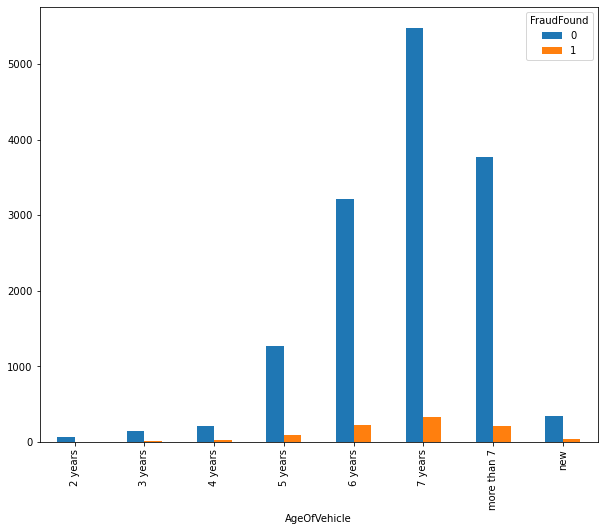

In [57]:
pd.crosstab(data['AgeOfVehicle'],data['FraudFound']).plot(kind='bar')
plt.show()

In [58]:
# Column called 'Age of Vehicle' had categories like '2years','3years','4years','6years','more than 7 years'
# but Category of '7years' and 'more than 7years' had most of the vehicles so it was binned accordingly

def vehcat(x):
    if x in ['new']:
        return 'Less than 1 year'
    if x in ['2 years','3 years','4 years']:
        return '2 to 4 years'
    if x in ['5 years','6 years']:
        return '5 to 6 years'
    else:
        return '7 & More than 7'
    
    
data['AgeOfVehicle']=data['AgeOfVehicle'].apply(vehcat)

stats.chi2_contingency(pd.crosstab(data['AgeOfVehicle'],data['FraudFound']))

(18.3352948277005,
 0.00037507833747261056,
 3,
 array([[ 426.82477302,   27.17522698],
        [4517.38553826,  287.61446174],
        [9202.11647211,  585.88352789],
        [ 350.6732166 ,   22.3267834 ]]))

In [59]:
data.head()

,Month,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,FraudFound
0,Q4,Honda,Urban,Q1,Female,Single,21,Policy Holder,Sport - Liability,"more than 69,000",300,1,more than 30,more than 30,none,2 to 4 years,26 to 30,No,No,External,none,1 year,3 to 4,0
1,Q1,Honda,Urban,Q1,Male,Single,34,Policy Holder,Sport - Collision,"more than 69,000",400,4,more than 30,more than 30,none,5 to 6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,0
2,Q4,Honda,Urban,Q4,Male,Married,47,Policy Holder,Sport - Collision,"more than 69,000",400,3,more than 30,more than 30,1,7 & More than 7,41 to 50,No,No,External,none,no change,1 vehicle,0
3,Q2,Toyota,Rural,Q3,Male,Married,65,Third Party,Sedan - Liability,"20,000 to 29,000",400,2,more than 30,more than 30,1,7 & More than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,0
4,Q1,Honda,Urban,Q1,Female,Single,27,Third Party,Sport - Collision,"more than 69,000",400,1,more than 30,more than 30,none,5 to 6 years,31 to 35,No,No,External,none,no change,1 vehicle,0


In [60]:
## For AgeOfPolicyHolder column we alreay have age column so we will drop it

data.drop('AgeOfPolicyHolder',axis=1,inplace=True)

In [61]:
data.head()

,Month,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,FraudFound
0,Q4,Honda,Urban,Q1,Female,Single,21,Policy Holder,Sport - Liability,"more than 69,000",300,1,more than 30,more than 30,none,2 to 4 years,No,No,External,none,1 year,3 to 4,0
1,Q1,Honda,Urban,Q1,Male,Single,34,Policy Holder,Sport - Collision,"more than 69,000",400,4,more than 30,more than 30,none,5 to 6 years,Yes,No,External,none,no change,1 vehicle,0
2,Q4,Honda,Urban,Q4,Male,Married,47,Policy Holder,Sport - Collision,"more than 69,000",400,3,more than 30,more than 30,1,7 & More than 7,No,No,External,none,no change,1 vehicle,0
3,Q2,Toyota,Rural,Q3,Male,Married,65,Third Party,Sedan - Liability,"20,000 to 29,000",400,2,more than 30,more than 30,1,7 & More than 7,Yes,No,External,more than 5,no change,1 vehicle,0
4,Q1,Honda,Urban,Q1,Female,Single,27,Third Party,Sport - Collision,"more than 69,000",400,1,more than 30,more than 30,none,5 to 6 years,No,No,External,none,no change,1 vehicle,0


In [62]:
data['AddressChange-Claim'].value_counts(normalize=True)*100

no change         92.892348
4 to 8 years       4.092088
2 to 3 years       1.887160
1 year             1.102464
under 6 months     0.025940
Name: AddressChange-Claim, dtype: float64

In [63]:
#  'Address change claim' column had 92% of data of 'no change' category hence it was kept same and other
# categories like '4 to 8 years','2 to 3 years' were combined together in category called 'change'.


def address(x):
    if x in ['no change']:
        return 'no change'
    else:
        return 'Change'
    
data['AddressChange-Claim']=data['AddressChange-Claim'].apply(address)

stats.chi2_contingency(pd.crosstab(data['AddressChange-Claim'],data['FraudFound']))

(17.75746187507465,
 2.5093135071962023e-05,
 1,
 array([[ 1030.39636835,    65.60363165],
        [13466.60363165,   857.39636835]]))

In [64]:
# for numberofcars column

# As per the statistical POV the number of cars is not providing any trend

data.drop('NumberOfCars',axis=1,inplace=True)

In [65]:
data.head()

,Month,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,FraudFound
0,Q4,Honda,Urban,Q1,Female,Single,21,Policy Holder,Sport - Liability,"more than 69,000",300,1,more than 30,more than 30,none,2 to 4 years,No,No,External,none,Change,0
1,Q1,Honda,Urban,Q1,Male,Single,34,Policy Holder,Sport - Collision,"more than 69,000",400,4,more than 30,more than 30,none,5 to 6 years,Yes,No,External,none,no change,0
2,Q4,Honda,Urban,Q4,Male,Married,47,Policy Holder,Sport - Collision,"more than 69,000",400,3,more than 30,more than 30,1,7 & More than 7,No,No,External,none,no change,0
3,Q2,Toyota,Rural,Q3,Male,Married,65,Third Party,Sedan - Liability,"20,000 to 29,000",400,2,more than 30,more than 30,1,7 & More than 7,Yes,No,External,more than 5,no change,0
4,Q1,Honda,Urban,Q1,Female,Single,27,Third Party,Sport - Collision,"more than 69,000",400,1,more than 30,more than 30,none,5 to 6 years,No,No,External,none,no change,0


In [66]:
data['Deductible'].value_counts()

400    14838
700      311
500      263
300        8
Name: Deductible, dtype: int64

In [67]:
# 'Deductible' column had categories like '400','500','700' and '300' but out of which 93% of data had category of '400'
# so it was kept as it is and rest of categories were combined in 'others'.

def deduct(x):
    if x=='400':
        return '400'
    else:
        return 'Others'
    
data['Deductible']=data['Deductible'].apply(deduct)

In [68]:
data.head()

,Month,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,FraudFound
0,Q4,Honda,Urban,Q1,Female,Single,21,Policy Holder,Sport - Liability,"more than 69,000",Others,1,more than 30,more than 30,none,2 to 4 years,No,No,External,none,Change,0
1,Q1,Honda,Urban,Q1,Male,Single,34,Policy Holder,Sport - Collision,"more than 69,000",Others,4,more than 30,more than 30,none,5 to 6 years,Yes,No,External,none,no change,0
2,Q4,Honda,Urban,Q4,Male,Married,47,Policy Holder,Sport - Collision,"more than 69,000",Others,3,more than 30,more than 30,1,7 & More than 7,No,No,External,none,no change,0
3,Q2,Toyota,Rural,Q3,Male,Married,65,Third Party,Sedan - Liability,"20,000 to 29,000",Others,2,more than 30,more than 30,1,7 & More than 7,Yes,No,External,more than 5,no change,0
4,Q1,Honda,Urban,Q1,Female,Single,27,Third Party,Sport - Collision,"more than 69,000",Others,1,more than 30,more than 30,none,5 to 6 years,No,No,External,none,no change,0


In [69]:
data['NumberOfSuppliments'].value_counts()

none           7047
more than 5    3867
1 to 2         2489
3 to 5         2017
Name: NumberOfSuppliments, dtype: int64

In [70]:
data['NumberOfSuppliments'].unique()

array(['none', 'more than 5', '3 to 5', '1 to 2'], dtype=object)

In [71]:
def Suppliments(x):
    if x in ['3 to 5','more than 5']:
        return '3 and More'
    else:
        return x
    
data['NumberOfSuppliments']=data['NumberOfSuppliments'].apply(Suppliments)

In [72]:
data.head()

,Month,Make,AccidentArea,MonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,FraudFound
0,Q4,Honda,Urban,Q1,Female,Single,21,Policy Holder,Sport - Liability,"more than 69,000",Others,1,more than 30,more than 30,none,2 to 4 years,No,No,External,none,Change,0
1,Q1,Honda,Urban,Q1,Male,Single,34,Policy Holder,Sport - Collision,"more than 69,000",Others,4,more than 30,more than 30,none,5 to 6 years,Yes,No,External,none,no change,0
2,Q4,Honda,Urban,Q4,Male,Married,47,Policy Holder,Sport - Collision,"more than 69,000",Others,3,more than 30,more than 30,1,7 & More than 7,No,No,External,none,no change,0
3,Q2,Toyota,Rural,Q3,Male,Married,65,Third Party,Sedan - Liability,"20,000 to 29,000",Others,2,more than 30,more than 30,1,7 & More than 7,Yes,No,External,3 and More,no change,0
4,Q1,Honda,Urban,Q1,Female,Single,27,Third Party,Sport - Collision,"more than 69,000",Others,1,more than 30,more than 30,none,5 to 6 years,No,No,External,none,no change,0


# Model Building 

# With imbalance data

In [73]:
encoded_data=pd.get_dummies(data,drop_first=True)

x=encoded_data.drop('FraudFound',axis=1)
y=encoded_data['FraudFound']

In [74]:
x.shape,y.shape

((15420, 47), (15420,))

In [75]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

DT=DecisionTreeClassifier()
RF=RandomForestClassifier()
xgb=XGBClassifier()
gbm=GradientBoostingClassifier()
lgbm=LGBMClassifier()
nb=GaussianNB()
knn=KNeighborsClassifier()

In [76]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.model_selection import train_test_split
lr=LogisticRegression()

In [77]:
logreg_forward = sfs(estimator=lr, k_features = 'best', forward=True,
                     verbose=2)

In [78]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,stratify=y,test_size=0.3)

In [79]:
sfs_forward = logreg_forward.fit(xtrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    1.7s finished

[2023-01-07 08:32:28] Features: 1/47 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    5.9s finished

[2023-01-07 08:32:34] Features: 2/47 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    7.2s finished

[2023-01-07 08:32:41] Features: 3/47 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   12.4s finished

[2023-01-07 08:38:18] Features: 29/47 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   11.9s finished

[2023-01-07 08:38:31] Features: 30/47 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   11.5s finished

[2023-01-07 08:38:42] Features: 31/47 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  1

In [80]:
forw=x.loc[:,sfs_forward.k_feature_names_]

In [81]:
sfs_forward.k_score_

0.940151942790938

In [82]:
# Checking for backward elimination

In [83]:
logreg_forward = sfs(estimator=lr, k_features = 'best', forward=False,
                     verbose=2)

In [84]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,stratify=y,test_size=0.3)

In [85]:
sfs_backward = logreg_forward.fit(xtrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:   32.5s finished

[2023-01-07 08:40:49] Features: 46/1 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:   31.8s finished

[2023-01-07 08:41:21] Features: 45/1 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   31.4s finished

[2023-01-07 08:41:53] Features: 44/1 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    8.5s finished

[2023-01-07 08:50:25] Features: 18/1 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    8.0s finished

[2023-01-07 08:50:33] Features: 17/1 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    7.4s finished

[2023-01-07 08:50:41] Features: 16/1 -- score: 0.940151942790938[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 o

In [86]:
len(sfs_backward.k_feature_names_)

47

In [87]:
    ## Backward elimination method is giving 46 features with 0.94 score

In [88]:
x=x.loc[:,sfs_backward.k_feature_names_]

In [89]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,stratify=y,test_size=0.3)        

In [90]:
# Logistic regression
lr=LogisticRegression()
model=lr.fit(xtrain,ytrain)

pred_lr=model.predict(xtest)

pred_prob_lr=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_lr))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.00      0.00      0.00       277

    accuracy                           0.94      4626
   macro avg       0.47      0.50      0.48      4626
weighted avg       0.88      0.94      0.91      4626



In [91]:
# Decision tree

model=DT.fit(xtrain,ytrain)

pred_dt=model.predict(xtest)

pred_prob_DT=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_dt))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4349
           1       0.14      0.15      0.14       277

    accuracy                           0.89      4626
   macro avg       0.54      0.55      0.54      4626
weighted avg       0.90      0.89      0.89      4626



In [92]:
# Random forest

model=RF.fit(xtrain,ytrain)

pred_RF=model.predict(xtest)

pred_prob_RF=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_RF))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.25      0.01      0.01       277

    accuracy                           0.94      4626
   macro avg       0.60      0.50      0.49      4626
weighted avg       0.90      0.94      0.91      4626



In [93]:
# XGboost

model=xgb.fit(xtrain,ytrain)

pred_xgb=model.predict(xtest)

pred_prob_xgb=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4349
           1       0.15      0.02      0.03       277

    accuracy                           0.93      4626
   macro avg       0.54      0.51      0.50      4626
weighted avg       0.89      0.93      0.91      4626



In [94]:
# KNN

model=knn.fit(xtrain,ytrain)

pred_knn=model.predict(xtest)

pred_prob_knn=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_knn))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.12      0.01      0.02       277

    accuracy                           0.94      4626
   macro avg       0.53      0.50      0.49      4626
weighted avg       0.89      0.94      0.91      4626



In [95]:
# GBM

model=gbm.fit(xtrain,ytrain)

pred_gbm=model.predict(xtest)

pred_prob_gbm=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_gbm))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4349
           1       0.00      0.00      0.00       277

    accuracy                           0.94      4626
   macro avg       0.47      0.50      0.48      4626
weighted avg       0.88      0.94      0.91      4626



* ROC-Curve for all models comparision

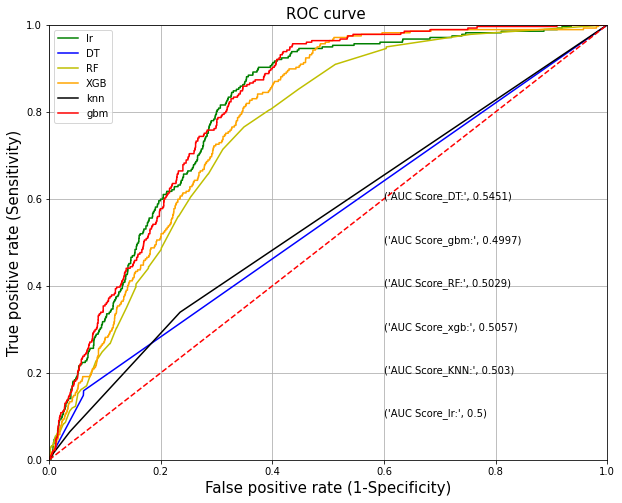

In [96]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
from sklearn.metrics import roc_curve # ROC
from sklearn.metrics import accuracy_score
from sklearn import metrics  # AUC
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function

fpr, tpr, thresholds = roc_curve(ytest,pred_prob_lr )

plt.plot(fpr, tpr,'-g',label='lr')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_DT)

plt.plot(fpr, tpr,'-b',label='DT')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_RF)

plt.plot(fpr, tpr,'-y',label='RF')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_xgb)

plt.plot(fpr, tpr,'orange',label='XGB')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_knn)

plt.plot(fpr, tpr,'black',label='knn')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_gbm)

plt.plot(fpr, tpr,'r',label='gbm')

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve ', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text
# use round() to round-off the AUC score upto 4 digits
auc_RF = round(metrics.roc_auc_score(ytest, pred_RF),4)
auc_xgb = round(metrics.roc_auc_score(ytest, pred_xgb),4)
auc_knn = round(metrics.roc_auc_score(ytest, pred_knn),4)
auc_lr = round(metrics.roc_auc_score(ytest, pred_lr),4)
auc_gbm = round(metrics.roc_auc_score(ytest, pred_gbm),4)
auc_dt = round(metrics.roc_auc_score(ytest, pred_dt),4)




plt.text(x = 0.6, y = 0.4, s = ('AUC Score_RF:', auc_RF))
plt.text(x = 0.6, y = 0.3, s = ('AUC Score_xgb:', auc_xgb))
plt.text(x = 0.6, y = 0.2, s = ('AUC Score_KNN:', auc_knn))
plt.text(x = 0.6, y = 0.1, s = ('AUC Score_lr:', auc_lr))
plt.text(x = 0.6, y = 0.5, s = ('AUC Score_gbm:', auc_gbm))
plt.text(x = 0.6, y = 0.6,s = ('AUC Score_DT:', auc_dt))



                               
# plot the grid
plt.grid(True)
plt.legend()
plt.show()

* Trying to balance the data using SMOTE-ANYALYSIS

In [97]:
#Importing the library

from imblearn.over_sampling import SMOTE

encoded_data=pd.get_dummies(data,drop_first=True)

x=encoded_data.drop('FraudFound',axis=1)
y=encoded_data['FraudFound']


sm=SMOTE(random_state=10,sampling_strategy=0.25)

In [98]:

x_resample,y_resample=sm.fit_resample(x,y)

#Checking the distribution of classes
y_resample.value_counts()

0    14497
1     3624
Name: FraudFound, dtype: int64

In [99]:
y_resample.value_counts(normalize=True)*100

0    80.001104
1    19.998896
Name: FraudFound, dtype: float64

# Remodeling with balance data

In [100]:
xtrain,xtest,ytrain,ytest=train_test_split(x_resample,y_resample,test_size=0.3,stratify=y_resample)

In [101]:
# Logistic regression

model=lr.fit(xtrain,ytrain)

pred_res_lr=model.predict(xtest)

pred_prob_res_lr=model.predict_proba(xtest)[:,1]

train_pred_lr=model.predict(xtrain)


print(classification_report(ytest,pred_res_lr))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      4350
           1       0.80      0.62      0.70      1087

    accuracy                           0.89      5437
   macro avg       0.85      0.79      0.82      5437
weighted avg       0.89      0.89      0.89      5437



In [102]:
# Decision tree

model=DT.fit(xtrain,ytrain)

pred_res_DT=model.predict(xtest)

pred_prob_res_DT=model.predict_proba(xtest)[:,1]

train_pred_DT=model.predict(xtrain)

print(classification_report(ytest,pred_res_DT))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4350
           1       0.67      0.74      0.70      1087

    accuracy                           0.87      5437
   macro avg       0.80      0.82      0.81      5437
weighted avg       0.88      0.87      0.88      5437



In [103]:
# Random forest

model=RF.fit(xtrain,ytrain)

pred_res_RF=model.predict(xtest)

pred_prob_res_RF=model.predict_proba(xtest)[:,1]

train_pred_RF=model.predict(xtrain)

print(classification_report(ytest,pred_res_RF))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4350
           1       0.87      0.72      0.79      1087

    accuracy                           0.92      5437
   macro avg       0.90      0.85      0.87      5437
weighted avg       0.92      0.92      0.92      5437



In [104]:
# Xgboost

model=xgb.fit(xtrain,ytrain)

pred_res_xgb=model.predict(xtest)

pred_prob_res_xgb=model.predict_proba(xtest)[:,1]

train_pred_xgb=model.predict(xtrain)

print(classification_report(ytest,pred_res_xgb))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      4350
           1       0.82      0.72      0.77      1087

    accuracy                           0.91      5437
   macro avg       0.87      0.84      0.86      5437
weighted avg       0.91      0.91      0.91      5437



In [105]:
# KNN

model=knn.fit(xtrain,ytrain)

pred_res_knn=model.predict(xtest)

pred_prob_res_knn=model.predict_proba(xtest)[:,1]

train_pred_knn=model.predict(xtrain)

print(classification_report(ytest,pred_res_knn))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      4350
           1       0.63      0.87      0.73      1087

    accuracy                           0.87      5437
   macro avg       0.80      0.87      0.82      5437
weighted avg       0.90      0.87      0.88      5437



In [106]:
# gbm

model=gbm.fit(xtrain,ytrain)

pred_res_gbm=model.predict(xtest)

pred_prob_res_gbm=model.predict_proba(xtest)[:,1]

train_pred_gbm=model.predict(xtrain)

print(classification_report(ytest,pred_res_gbm))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      4350
           1       0.84      0.58      0.69      1087

    accuracy                           0.89      5437
   macro avg       0.87      0.78      0.81      5437
weighted avg       0.89      0.89      0.89      5437



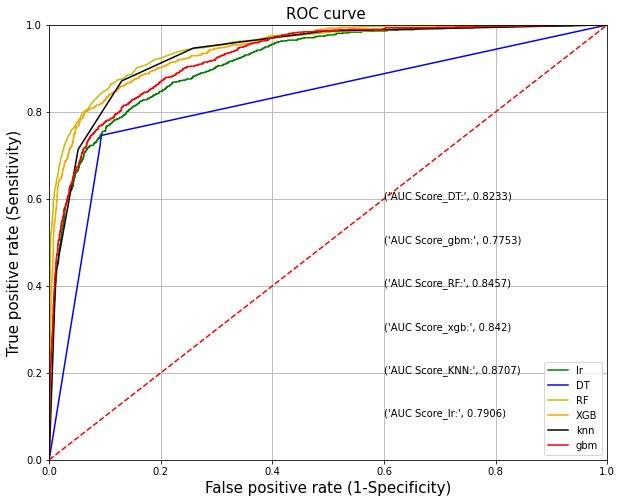

In [107]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
from sklearn.metrics import roc_curve # ROC
from sklearn.metrics import accuracy_score
from sklearn import metrics  # AUC
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function

fpr, tpr, thresholds = roc_curve(ytest,pred_prob_res_lr )

plt.plot(fpr, tpr,'-g',label='lr')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_DT)

plt.plot(fpr, tpr,'-b',label='DT')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_RF)

plt.plot(fpr, tpr,'-y',label='RF')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_xgb)

plt.plot(fpr, tpr,'orange',label='XGB')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_knn)

plt.plot(fpr, tpr,'black',label='knn')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_gbm)

plt.plot(fpr, tpr,'r',label='gbm')

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve ', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text
# use round() to round-off the AUC score upto 4 digits
auc_RF = round(metrics.roc_auc_score(ytest, pred_res_RF),4)
auc_xgb = round(metrics.roc_auc_score(ytest, pred_res_xgb),4)
auc_knn = round(metrics.roc_auc_score(ytest, pred_res_knn),4)
auc_lr = round(metrics.roc_auc_score(ytest, pred_res_lr),4)
auc_gbm = round(metrics.roc_auc_score(ytest, pred_res_gbm),4)
auc_dt = round(metrics.roc_auc_score(ytest, pred_res_DT),4)


plt.text(x = 0.6, y = 0.4, s = ('AUC Score_RF:', auc_RF))
plt.text(x = 0.6, y = 0.3, s = ('AUC Score_xgb:', auc_xgb))
plt.text(x = 0.6, y = 0.2, s = ('AUC Score_KNN:', auc_knn))
plt.text(x = 0.6, y = 0.1, s = ('AUC Score_lr:', auc_lr))
plt.text(x = 0.6, y = 0.5, s = ('AUC Score_gbm:', auc_gbm))
plt.text(x = 0.6, y = 0.6,s = ('AUC Score_DT:', auc_dt))

plt.grid(True)
plt.legend()
plt.show()

In [108]:
comparison=pd.DataFrame()
comparison['Type']=['Train','Test']
comparison['Logistic regression']=round(accuracy_score(ytrain,train_pred_lr),3),round(accuracy_score(ytest,pred_res_lr),3)
comparison['Decision tree']=round(accuracy_score(ytrain,train_pred_DT),3),round(accuracy_score(ytest,pred_res_DT),3)
comparison['Random Forest']=round(accuracy_score(ytrain,train_pred_RF),3),round(accuracy_score(ytest,pred_res_RF),3)
comparison['XGboost']=round(accuracy_score(ytrain,train_pred_xgb),3),round(accuracy_score(ytest,pred_res_xgb),3)
comparison['GBM']=round(accuracy_score(ytrain,train_pred_gbm),3),round(accuracy_score(ytest,pred_res_gbm),3)
comparison['KNN']=round(accuracy_score(ytrain,train_pred_knn),3),round(accuracy_score(ytest,pred_res_knn),3)

In [109]:
compariosn

NameError: name 'compariosn' is not defined

# Using hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# XGB grid

In [ ]:
tuned_parameters=[{"n_estimators" : [100,200],
                   'learning_rate':[0.1],
                   'max_depth' : [5,7],
                  'max_leaves':[1,2],
                  'min_child_weight':[1],
                  'gamma':[0,0.1,0.4,0.3]}]

xgbmodel=XGBClassifier(random_state=10)

xgb_grid=GridSearchCV(estimator=xgbmodel,
                     param_grid=tuned_parameters,
                     cv=3)
xgbmodel=xgb_grid.fit(xtrain,ytrain)

xgbmodel.best_params_

In [ ]:
xgb=XGBClassifier( gamma= 0,
 learning_rate= 0.1,
 max_depth= 7,
 max_leaves=1,
 min_child_weight=1,
 n_estimators=200)

model=xgb.fit(xtrain,ytrain)

pred_grid_xgb=model.predict(xtest)

train_grid_xgb=model.predict(xtrain)

pred_prob_grid_xgb=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_grid_xgb))

In [ ]:
# logistic regression grid

In [ ]:
tuned_parameters=[{'penalty' : ['l1', 'l2', 'none'],
    'solver' : ['lbfgs','newton-cg','liblinear'],
    'max_iter' : [100, 1000,2000]}]

lr=LogisticRegression(random_state=10)

lr_grid=GridSearchCV(estimator=lr,
                     param_grid=tuned_parameters,
                     cv=3)
lrmodel=lr_grid.fit(xtrain,ytrain)

lrmodel.best_params_

In [ ]:
lr=LogisticRegression(max_iter=1000, penalty= 'none', solver='lbfgs' )

model=lr.fit(xtrain,ytrain)

pred_grid_lr=model.predict(xtest)

train_grid_lr=model.predict(xtrain)

pred_prob_grid_lr=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_grid_lr))

In [ ]:
# KNN Grid

In [ ]:
tuned_parameters=[{'n_neighbors' : [5,7,9,11,13],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}]

knn=KNeighborsClassifier()

knn_grid=GridSearchCV(estimator=knn,
                     param_grid=tuned_parameters,
                     cv=3)
knnmodel=knn_grid.fit(xtrain,ytrain)

knnmodel.best_params_

In [ ]:
knn=KNeighborsClassifier(metric='manhattan', n_neighbors= 13, weights= 'distance' )

model=knn.fit(xtrain,ytrain)

pred_grid_knn=model.predict(xtest)

train_grid_knn=model.predict(xtrain)

pred_prob_grid_knn=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_grid_knn))

In [ ]:
tuned_parameters=[{'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7]}]

gbm=GradientBoostingClassifier(random_state=10)

gbm_grid=GridSearchCV(estimator=gbm,
                     param_grid=tuned_parameters,
                     cv=3)
gbmmodel=gbm_grid.fit(xtrain,ytrain)

gbmmodel.best_params_

In [ ]:
gbm=GradientBoostingClassifier(learning_rate= 0.5)

model=gbm.fit(xtrain,ytrain)

pred_grid_gbm=model.predict(xtest)

train_grid_gbm=model.predict(xtrain)

pred_prob_grid_gbm=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_grid_gbm))

In [ ]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
from sklearn.metrics import roc_curve # ROC
from sklearn.metrics import accuracy_score
from sklearn import metrics  # AUC
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function

fpr, tpr, thresholds = roc_curve(ytest,pred_prob_grid_lr )

plt.plot(fpr, tpr,'-g',label='lr')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_grid_xgb)

plt.plot(fpr, tpr,'orange',label='XGB')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_grid_knn)

plt.plot(fpr, tpr,'black',label='knn')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_grid_gbm)

plt.plot(fpr, tpr,'r',label='gbm')

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve ', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text
# use round() to round-off the AUC score upto 4 digits
auc_xgb = round(metrics.roc_auc_score(ytest, pred_grid_xgb),4)
auc_knn = round(metrics.roc_auc_score(ytest, pred_grid_knn),4)
auc_lr = round(metrics.roc_auc_score(ytest, pred_grid_lr),4)
auc_gbm = round(metrics.roc_auc_score(ytest, pred_grid_gbm),4)


plt.text(x = 0.6, y = 0.3, s = ('AUC Score_xgb:', auc_xgb))
plt.text(x = 0.6, y = 0.2, s = ('AUC Score_KNN:', auc_knn))
plt.text(x = 0.6, y = 0.1, s = ('AUC Score_lr:', auc_lr))
plt.text(x = 0.6, y = 0.4, s = ('AUC Score_gbm:', auc_gbm))

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
comparison2=pd.DataFrame()
comparison2['Type']=['Train','Test']
comparison2['Logistic regression']=round(accuracy_score(ytrain,train_grid_lr),3),round(accuracy_score(ytest,pred_grid_lr),3)
comparison2['XGboost']=round(accuracy_score(ytrain,train_grid_xgb),2),round(accuracy_score(ytest,pred_grid_xgb),2)
comparison2['KNN']=round(accuracy_score(ytrain,train_grid_knn),3),round(accuracy_score(ytest,pred_grid_knn),3)
comparison2['gbm']=round(accuracy_score(ytrain,train_grid_gbm),2),round(accuracy_score(ytest,pred_grid_gbm),2)

comparison2

In [ ]:
model_performance=pd.DataFrame()
model_performance['GridsearchCV']=['Train','Test']
model_performance['Accuracy score']=[(np.round(accuracy_score(ytrain,train_grid_xgb),2)),(np.round(accuracy_score(ytest,pred_grid_xgb),2))]
model_performance['F1 score score']=[(np.round(f1_score(ytrain,train_grid_xgb),2)),(np.round(f1_score(ytest,pred_grid_xgb),2))]
model_performance['Precision score']=[(np.round(precision_score(ytrain,train_grid_xgb),2)),(np.round(precision_score(ytest,pred_grid_xgb),2))]
model_performance['Recall score']=[(np.round(recall_score(ytrain,train_grid_xgb),2)),(np.round(recall_score(ytest,pred_grid_xgb),2))]
model_performance=model_performance.set_index('GridsearchCV').T
model_performance

* Comparsion of Train vs Test ...(visualization)

In [ ]:
model_performance[['Train','Test']].plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('Metrics',fontsize=15)
plt.ylabel('Scores',fontsize=15)
plt.title('Comparison of Train vs Test scores')
plt.show()

In [ ]:
# Comparing roc-auc curve before grid and after grid

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(121)



# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
from sklearn.metrics import roc_curve # ROC
from sklearn.metrics import accuracy_score
from sklearn import metrics  # AUC
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function

fpr, tpr, thresholds = roc_curve(ytest,pred_prob_res_lr )

plt.plot(fpr, tpr,'-g',label='lr')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_DT)

plt.plot(fpr, tpr,'-b',label='DT')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_RF)

plt.plot(fpr, tpr,'-y',label='RF')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_xgb)

plt.plot(fpr, tpr,'orange',label='XGB')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_knn)

plt.plot(fpr, tpr,'black',label='knn')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_res_gbm)

plt.plot(fpr, tpr,'r',label='gbm')

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('resampling curve ', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text
# use round() to round-off the AUC score upto 4 digits
auc_RF = round(metrics.roc_auc_score(ytest, pred_res_RF),4)
auc_xgb = round(metrics.roc_auc_score(ytest, pred_res_xgb),4)
auc_knn = round(metrics.roc_auc_score(ytest, pred_res_knn),4)
auc_lr = round(metrics.roc_auc_score(ytest, pred_res_lr),4)
auc_gbm = round(metrics.roc_auc_score(ytest, pred_res_gbm),4)
auc_dt = round(metrics.roc_auc_score(ytest, pred_res_DT),4)


plt.text(x = 0.6, y = 0.4, s = ('AUC Score_RF:', auc_RF))
plt.text(x = 0.6, y = 0.3, s = ('AUC Score_xgb:', auc_xgb))
plt.text(x = 0.6, y = 0.2, s = ('AUC Score_KNN:', auc_knn))
plt.text(x = 0.6, y = 0.1, s = ('AUC Score_lr:', auc_lr))
plt.text(x = 0.6, y = 0.5, s = ('AUC Score_gbm:', auc_gbm))
plt.text(x = 0.6, y = 0.6,s = ('AUC Score_DT:', auc_dt))

plt.grid(True)
plt.legend()

plt.subplot(122)
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
from sklearn.metrics import roc_curve # ROC
from sklearn.metrics import accuracy_score
from sklearn import metrics  # AUC
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function

fpr, tpr, thresholds = roc_curve(ytest,pred_prob_grid_lr )

plt.plot(fpr, tpr,'-g',label='lr')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_grid_xgb)

plt.plot(fpr, tpr,'orange',label='XGB')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_grid_knn)

plt.plot(fpr, tpr,'black',label='knn')

fpr, tpr, thresholds = roc_curve(ytest, pred_prob_grid_gbm)

plt.plot(fpr, tpr,'r',label='gbm')

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Resampling + Grid curve ', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text
# use round() to round-off the AUC score upto 4 digits
auc_xgb = round(metrics.roc_auc_score(ytest, pred_grid_xgb),4)
auc_knn = round(metrics.roc_auc_score(ytest, pred_grid_knn),4)
auc_lr = round(metrics.roc_auc_score(ytest, pred_grid_lr),4)
auc_gbm = round(metrics.roc_auc_score(ytest, pred_grid_gbm),4)


plt.text(x = 0.6, y = 0.3, s = ('AUC Score_xgb:', auc_xgb))
plt.text(x = 0.6, y = 0.2, s = ('AUC Score_KNN:', auc_knn))
plt.text(x = 0.6, y = 0.1, s = ('AUC Score_lr:', auc_lr))
plt.text(x = 0.6, y = 0.4, s = ('AUC Score_gbm:', auc_gbm))

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Further Steps

In [ ]:
# Trying Randomized search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
xgb=XGBClassifier()

In [ ]:
params={'learning_rate':[0.05,0.10,0.15,0.20,0.25,0.30,0.4,0.45],
        'max_depth':[3,5,7,10,13,15,20],
        'min_child_weight':[1,3,5],
        'gamma':[0.0,0.1,0.2,0.3,0.4,0.5],
        'colsample_bytree':[0.3,0.7,0.5,0.7,0.9]}

Random_search=RandomizedSearchCV(estimator=xgb,
                                 param_distributions=params,cv=3,
                                 scoring='roc_auc',n_jobs=-1,
                                 verbose=2)

Random_search.fit(xtrain,ytrain)

In [ ]:
Random_search.best_estimator_

In [ ]:
xxgb=XGBClassifier( base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.25, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=20, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0)

model=xgb.fit(xtrain,ytrain)

pred_Random_grid_xgb=model.predict(xtest)

train_Random_grid_xgb=model.predict(xtrain)

pred_prob_random_grid_xgb=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_Random_grid_xgb))

In [ ]:
Random_search.best_params_

In [ ]:
xxgb=XGBClassifier( min_child_weight= 1,
 max_depth= 20,
 learning_rate= 0.25,
 gamma=0.3,
 colsample_bytree= 0.9)

model=xgb.fit(xtrain,ytrain)

pred_Random_grid_xgb=model.predict(xtest)

train_Random_grid_xgb=model.predict(xtrain)

pred_prob_random_grid_xgb=model.predict_proba(xtest)[:,1]

print(classification_report(ytest,pred_Random_grid_xgb))

In [ ]:
#Here we can clearly see that the model is performing same as gridsearch

In [ ]:
# Please Ignore Below Work

In [ ]:
fow=x.loc[:,sfs_backward.k_feature_names_]

In [ ]:
y

In [ ]:
#Importing the library

sm=SMOTE(random_state=10,sampling_strategy=0.25)
x_resample,y_resample=sm.fit_resample(forw,y)

#Checking the distribution of classes
y_resample.value_counts()

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_resample,y_resample,test_size=0.3,stratify=y_resample)

In [ ]:
xgb=XGBClassifier()
params={
    'learning_rate':[0.05,0.10,0.15,0.20,0.25,0.30,0.4,0.45],
    'max_depth':[3,5,7,10,13,15,20],
    'min_child_weight':[1,3,5],
    'gamma':[0.0,0.1,0.2,0.3,0.4,0.5],
    'colsample_bytree':[0.3,0.7,0.5,0.7,0.9]
}

Random_search=RandomizedSearchCV(estimator=xgb,param_distributions=params,cv=3,scoring='roc_auc',n_jobs=-1,verbose=2)

Random_search.fit(x_train,y_train)

In [ ]:
Random_search.best_params_

In [ ]:
xxgb=XGBClassifier( min_child_weight= 1,
 max_depth= 20,
 learning_rate= 0.4,
 gamma=0.4,
 colsample_bytree= 0.5)

model=xgb.fit(x_train,y_train)

pred_Random_grid_xgb=model.predict(x_test)

train_Random_grid_xgb=model.predict(x_train)

pred_prob_random_grid_xgb=model.predict_proba(x_test)[:,1]

print(classification_report(ytest,pred_Random_grid_xgb))